# Import libraries

In [1]:
# Re-install transformers
# !pip install -q transformers==4.55.4 faiss-cpu

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import numpy as np
from safetensors.torch import load_model

In [3]:
from transformers import (
    BertTokenizer,
    DataCollatorWithPadding,
    ErnieConfig,
    ErnieModel,
)

In [4]:
import gc
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, recall_score, precision_score

In [5]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

# Set seed for deterministic

In [6]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
# torch.use_deterministic_algorithms(True) 

# Constants

In [7]:
PATH_TO_DATASET = '/mnt/d/SemEval2026/subtask1'
MODEL_NAME = '/mnt/d/SemEval2026/ernie-3.0-xbase-zh'
BATCH_SIZE_TRAIN = 24
BATCH_SIZE_EVAL = 32

MODEL_PROJECTION_DIM = 256

LANG = 'zho'
NUM_CLASSES = 2
K_FOLDS = 5

SAVE_DIR = f'/mnt/d/SemEval2026/Ernie3-Sub1-Final-{LANG}'
TEMP_DIR = f'/mnt/d/SemEval2026/Ernie3-Sub1-temp-{LANG}'

In [8]:
SUBTASK2_COLUMNS = ['political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']
SUBTASK3_COLUMNS = ['stereotype','vilification','dehumanization','extreme_language','lack_of_empathy','invalidation']

# Prepare tokenizer and model

In [9]:
class ErnieSoftTripleModel(nn.Module):
    def __init__(self, model_name='nghuyong/ernie-3.0-xbase-zh', proj_dim=256, load_pretrained_encoder=True):
        super().__init__()
        if load_pretrained_encoder:
            self.encoder = ErnieModel.from_pretrained(model_name)
        else:
            self.encoder = ErnieModel(ErnieConfig.from_pretrained(model_name))
        self.config = self.encoder.config
        self.hidden_size = self.config.hidden_size
        
        self.projection = nn.Sequential(
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.GELU(),
            nn.LayerNorm(self.hidden_size),
            nn.Linear(self.hidden_size, proj_dim)
        )

    def forward(self, input_ids, attention_mask, labels=None, **kwargs):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)

        # 1. Extract [CLS] Token (Intent)
        cls_embedding = outputs.last_hidden_state[:, 0, :] # [Batch, Hidden]

        # Project to metric space (Stage 1)
        projected = F.normalize(self.projection(cls_embedding), p=2, dim=1)
        cls_embedding = F.normalize(cls_embedding, p=2, dim=1)

        return {'loss': None, 'projected': projected, 'embeddings': cls_embedding}

In [10]:
# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# Prepare dataset

In [11]:
class PolarizationDataset(torch.utils.data.Dataset):
  def __init__(self, data, tokenizer, max_length=96):
    """
    Args:
      data: Dict with 'texts', 'labels', and 'ids' keys
    """
    self.tokenizer = tokenizer
    self.max_length = max_length

    if isinstance(data, dict):
      self.texts = data['texts']
      self.labels = data['labels']
      # Add ID support. If not present, generate dummy IDs (0...N)
      self.ids = data.get('ids', list(range(len(self.texts))))
    else:
      raise ValueError("Data must be a single dict with 'texts', 'labels', and 'ids'")

    self.has_labels = any(label is not None for label in self.labels)

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = self.texts[idx]
    label = self.labels[idx] if self.has_labels else None
    sample_id = self.ids[idx]

    encoding = self.tokenizer(
      text,
      truncation=True,
      padding='max_length', # Changed to max_length for consistent tensor shapes in batch
      max_length=self.max_length,
      return_tensors='pt'
    )

    item = {key: encoding[key].squeeze() for key in encoding.keys()}

    if label is not None:
      item['labels'] = torch.tensor(int(label > 0), dtype=torch.long)
    
    # Return ID so we can verify if needed, though Sampler handles the logic
    item['id'] = sample_id 

    return item

In [12]:
train_path = PATH_TO_DATASET + f'/train/{LANG}.csv'
df = pd.read_csv(train_path)

In [13]:
PATH_TO_DATASET_SUBTASK2 = '/mnt/d/SemEval2026/subtask2'
df_sub2 = pd.read_csv(
    PATH_TO_DATASET_SUBTASK2 + f'/train/{LANG}.csv'
)

In [14]:
df = df.merge(
    df_sub2.drop(columns=['text']),
    on='id',
    how='left'
)

In [15]:
def prepare_data_and_folds(df, df_sub2, n_splits=5, seed=SEED):
    """
    1. Merges Subtask 1 and 2.
    2. Generates 'stage1_target' (0-5) for Metric Learning.
    3. Creates Multilabel Stratified Folds.
    
    Returns: 
        df (updated with 'stage1_target'), 
        fold_idx (list of train/val tuples)
    """
    print(f"Original df shape: {df.shape}")
    
    # --- STEP 2: GENERATE STAGE 1 TARGETS (The Geometry Fix) ---
    # We map Multi-Label vectors to a Single Integer for Triplet Loss.
    # Priority: Gender > Religious > Race > Political > Other
    # Reasoning: 'Gender' is the hardest implicit class. 'Religious' is the smallest minority.
    
    def get_fine_grained_label(row):
        if row['polarization'] == 0:
            return 0  # Class 0: Safe
        
        # Priority Check for Hate Topics
        if row['gender/sexual'] == 1: return 4  # Class 4: Gender (High Priority!)
        if row['religious'] == 1:     return 3  # Class 3: Religious (Protect Minority)
        if row['racial/ethnic'] == 1: return 2  # Class 2: Race (Dominant)
        if row['political'] == 1:     return 1  # Class 1: Politics
        if row['other'] == 1:         return 5  # Class 5: Other
        
        return 5 # Fallback

    print("Generating Fine-Grained Labels for Stage 1...")
    df['polarization'] = df.apply(get_fine_grained_label, axis=1)
    
    # --- STEP 3: STRATIFIED SPLIT (The Variance Fix) ---
    # Stratify on: Main Label + All 5 Topics
    y_main = df['polarization'].values.reshape(-1, 1)
    y_sub2 = df_sub2[SUBTASK2_COLUMNS].values
    stratify_targets = np.hstack([y_main, y_sub2])
    
    print(f"Running Multilabel Stratified K-Fold (n={n_splits})...")
    mskf = MultilabelStratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    
    fold_idx = []
    for train_idx, val_idx in mskf.split(df, stratify_targets):
        fold_idx.append((train_idx, val_idx))

    # Return the modified DF (so you can access 'stage1_target' later) and the indices
    return df, fold_idx

In [16]:
df, fold_idx = prepare_data_and_folds(df, df_sub2, n_splits=K_FOLDS, seed=SEED)

Original df shape: (4280, 8)
Generating Fine-Grained Labels for Stage 1...
Running Multilabel Stratified K-Fold (n=5)...


# Training process

## Collator

In [17]:
data_collator = DataCollatorWithPadding(tokenizer)

# Inferences on test set

## Load all fold models

In [18]:
model_list = []
for i in range(K_FOLDS):
    print(f"Intialize model fold {i+1}")
    model = ErnieSoftTripleModel(
        model_name=MODEL_NAME, 
        proj_dim=MODEL_PROJECTION_DIM,
        load_pretrained_encoder=False
    )
    load_model(model, f"{SAVE_DIR}/fold_{i+1}_best_model/model.safetensors")
    model.eval()
    model.cuda()
    model_list.append(model)

Intialize model fold 1
Intialize model fold 2
Intialize model fold 3
Intialize model fold 4
Intialize model fold 5


## Load test dataset (same for all subtasks)

In [19]:
# PUBLIC TEST WITH LABELS
PATH_TO_PUBLIC_TEST_WITH_LABELS = '/mnt/d/SemEval2026/test_phase/subtask1/dev'
test = pd.read_csv(PATH_TO_PUBLIC_TEST_WITH_LABELS + f'/{LANG}.csv')
test_dataset = PolarizationDataset({
    'texts': test['text'].tolist(),
    'labels': test['polarization'].tolist()
}, tokenizer=tokenizer)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE_EVAL,
    shuffle=False,
    collate_fn=data_collator
)

## Get embeddings of subsets for all folds

In [20]:
fold_train_embeddings = []
fold_val_embeddings = []
fold_test_embeddings = []

In [21]:
for fold_ids, (fold_train, fold_val) in enumerate(fold_idx):
    print(f"Generating embeddings for fold {fold_ids+1}")

    train_texts = [df['text'][j] for j in fold_train]
    val_texts = [df['text'][j] for j in fold_val]

    fold_train_data = {
        'texts': train_texts,
        'labels': [None] * len(train_texts)
    }
    fold_val_data = {
        'texts': val_texts,
        'labels': [None] * len(val_texts)
    }

    fold_train_dataset = PolarizationDataset(fold_train_data, tokenizer)
    fold_val_dataset = PolarizationDataset(fold_val_data, tokenizer)

    fold_train_dataloader = DataLoader(
        fold_train_dataset,
        batch_size=BATCH_SIZE_EVAL,
        shuffle=False,
        collate_fn=data_collator
    )
    fold_val_dataloader = DataLoader(
        fold_val_dataset,
        batch_size=BATCH_SIZE_EVAL,
        shuffle=False,
        collate_fn=data_collator
    )

    # Get the model for this fold
    model = model_list[fold_ids]

    # Generate Train Embeddings
    train_embeddings = []
    with torch.no_grad():
        for batch in fold_train_dataloader:
            batch = {k: v.cuda() for k, v in batch.items()}
            outputs = model(**batch)
            train_embeddings.append(outputs['projected'].cpu().numpy())
    train_embeddings = np.vstack(train_embeddings)
    train_embeddings = torch.tensor(train_embeddings)
    fold_train_embeddings.append(train_embeddings)

    # Generate Val Embeddings
    val_embeddings = []
    with torch.no_grad():
        for batch in fold_val_dataloader:
            batch = {k: v.cuda() for k, v in batch.items()}
            outputs = model(**batch)
            val_embeddings.append(outputs['projected'].cpu().numpy())
    val_embeddings = np.vstack(val_embeddings)
    val_embeddings = torch.tensor(val_embeddings)
    fold_val_embeddings.append(val_embeddings)

    # Generate Test Embeddings
    test_embeddings = []
    with torch.no_grad():
        for batch in test_dataloader:
            batch = {k: v.cuda() for k, v in batch.items()}
            outputs = model(**batch)
            test_embeddings.append(outputs['projected'].cpu().numpy())
    test_embeddings = np.vstack(test_embeddings)
    test_embeddings = torch.tensor(test_embeddings)
    fold_test_embeddings.append(test_embeddings)

    # Clean up
    del fold_train_dataset
    del fold_val_dataset
    del fold_train_dataloader
    del fold_val_dataloader
    gc.collect()
    torch.cuda.empty_cache()

Generating embeddings for fold 1
Generating embeddings for fold 2
Generating embeddings for fold 3
Generating embeddings for fold 4
Generating embeddings for fold 5


## Generate the result

In [22]:
df['polarization'] = (df['polarization'] > 0).astype(int) # Convert back to binary for evaluation of Subtask 1

In [23]:
fold_dataset = []
fold_index = []

for i, (train_index, val_index) in enumerate(fold_idx):
    print(f"Starting fold {i+1}")

    fold_index.append((train_index, val_index))

    # Prepare fold-specific datasets
    fold_train_data = {
        'texts': [df['text'][j] for j in train_index],
        'labels': [df['polarization'][j] for j in train_index]
    }
    fold_val_data = {
        'texts': [df['text'][j] for j in val_index],
        'labels': [df['polarization'][j] for j in val_index]
    }

    fold_train_dataset = PolarizationDataset(fold_train_data, tokenizer)
    fold_val_dataset = PolarizationDataset(fold_val_data, tokenizer)

    fold_dataset.append((fold_train_dataset, fold_val_dataset))

Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Starting fold 5


In [24]:
def knn_inference(k=5):
    """
    Calculates the optimal threshold for EACH fold independently,
    then returns the average of these thresholds.
    """
    fold_predictions = []

    for fold_ids, (fold_train, _) in enumerate(fold_dataset):
        fold_embeddings = fold_train_embeddings[fold_ids]
        test_embeddings = fold_test_embeddings[fold_ids]

        sim_matrix = torch.matmul(test_embeddings, fold_embeddings.t())
    
        # Get Top K indices
        # values: cosine scores, indices: index in train_labels
        values, indices = sim_matrix.topk(k, dim=1) 
        
        # Retrieve Neighbor Labels
        # Convert fold_train.labels to tensor if it's not already
        train_labels_tensor = torch.tensor(fold_train.labels, dtype=torch.long) if not isinstance(fold_train.labels, torch.Tensor) else fold_train.labels
        # Flatten indices, retrieve labels, then reshape back
        neighbor_labels = train_labels_tensor[indices.flatten()].reshape(indices.shape) # Shape: [N_Test, k]
        
        # --- Step 4: Simple Majority Vote (Mean) ---
        preds = neighbor_labels.float().mean(dim=1)
        fold_predictions.append(preds.cpu().numpy())

    predictions = np.mean(fold_predictions, axis=0)
    return predictions

### Evaluate the public test results

In [25]:
ground_truth = test_dataset.labels

In [26]:
search_k_range = np.linspace(3, 61, 19)
search_thresholds = np.linspace(0.01, 0.99, 99)

best_f1 = 0.0
best_k = 3
best_threshold = 0.5

for k in search_k_range:
    knn_res = knn_inference(k=int(k))
    for threshold in search_thresholds:
        preds = (knn_res >= threshold).astype(int)
        f1 = f1_score(ground_truth, preds, average='macro')
        if f1 > best_f1:
            best_f1 = f1
            best_k = int(k)
            best_threshold = threshold

best_f1, best_k, best_threshold

(0.9391872691105427, 9, np.float64(0.18000000000000002))

In [27]:
knn_res = knn_inference(k=best_k)
predicted_labels = (knn_res >= best_threshold).astype(int)

knn_res.min(), knn_res.max(), knn_res.mean()

(np.float32(0.0), np.float32(1.0), np.float32(0.47881624))

In [28]:
macro_f1 = f1_score(ground_truth, predicted_labels, average='macro')
precision = precision_score(ground_truth, predicted_labels, average='macro')
recall = recall_score(ground_truth, predicted_labels, average='macro')

In [29]:
print(f"Macro F1: {macro_f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

Macro F1: 0.9392, Precision: 0.9398, Recall: 0.9390


# Visualize embeddings space

In [31]:
palette = {
    0: 'blue', 1: 'green'
}

In [32]:
def get_embeddings_and_labels(model, dataloader):
    embeddings = []
    labels = []

    # Iterate over the training data in batches
    with torch.no_grad():  # Disable gradient calculation for inference
        for batch in dataloader:
            # Move batch to the same device as the model
            batch = {k: v.to('cuda') for k, v in batch.items()}

            # Get model outputs with hidden states
            outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], output_hidden_states=True)

            # Extract the embeddings and the labels
            batch_embeddings = outputs['embeddings'].cpu().numpy()
            batch_labels = batch['labels'].cpu().numpy()

            embeddings.append(batch_embeddings)
            labels.append(batch_labels)

    # Concatenate embeddings and labels from all batches
    embeddings = np.concatenate(embeddings)
    labels = np.concatenate(labels)

    return embeddings, labels

In [33]:
def visualize(lang, pca_embeddings, tsne_embeddings, labels):
    # Create a figure and a set of subplots (1 row, 2 columns)
    # This gives us explicit control over the figure (fig) and axes (axes)
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # --- PCA Plot ---
    # Tell seaborn to draw on the first subplot: axes[0]
    sns.scatterplot(x=pca_embeddings[:, 0], y=pca_embeddings[:, 1], hue=labels, palette=palette, legend='full', ax=axes[0])
    axes[0].set_title(f'PCA of ENRIE3.0 Embeddings for {lang}')
    axes[0].set_xlabel('PCA Component 1')
    axes[0].set_ylabel('PCA Component 2')

    # --- t-SNE Plot ---
    # Tell seaborn to draw on the second subplot: axes[1]
    sns.scatterplot(x=tsne_embeddings[:, 0], y=tsne_embeddings[:, 1], hue=labels, palette=palette, legend='full', ax=axes[1])
    axes[1].set_title(f't-SNE of ENRIE3.0 Embeddings for {lang}')
    axes[1].set_xlabel('t-SNE Component 1')
    axes[1].set_ylabel('t-SNE Component 2')

    # Adjust layout and display the figure
    fig.tight_layout()
    plt.show()

    # Explicitly close the figure object to free up memory
    plt.close(fig)

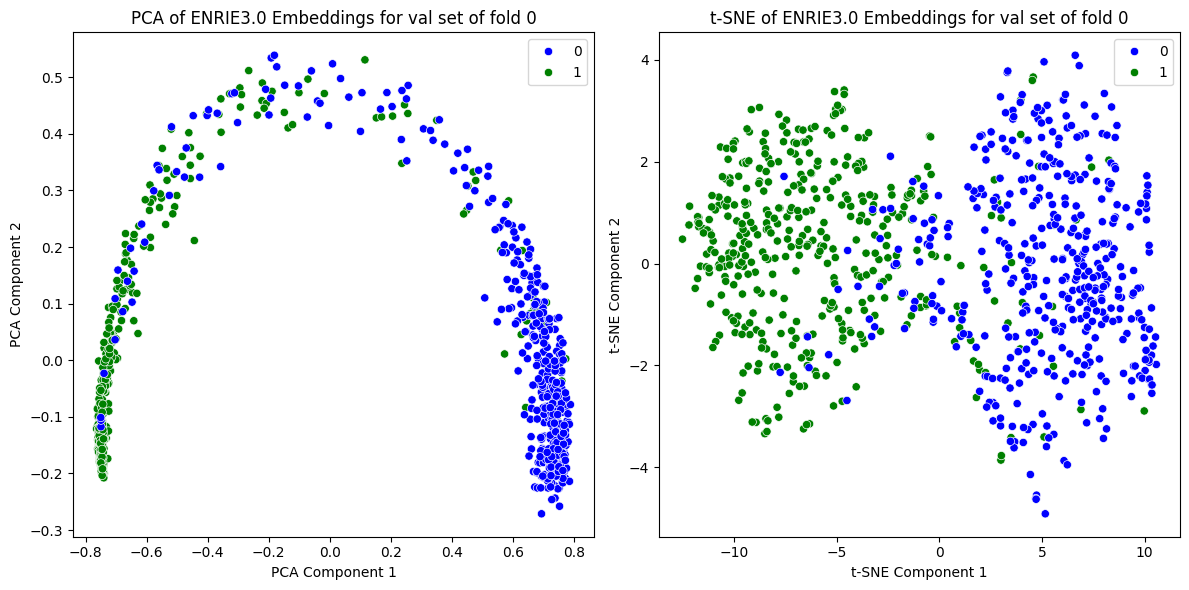

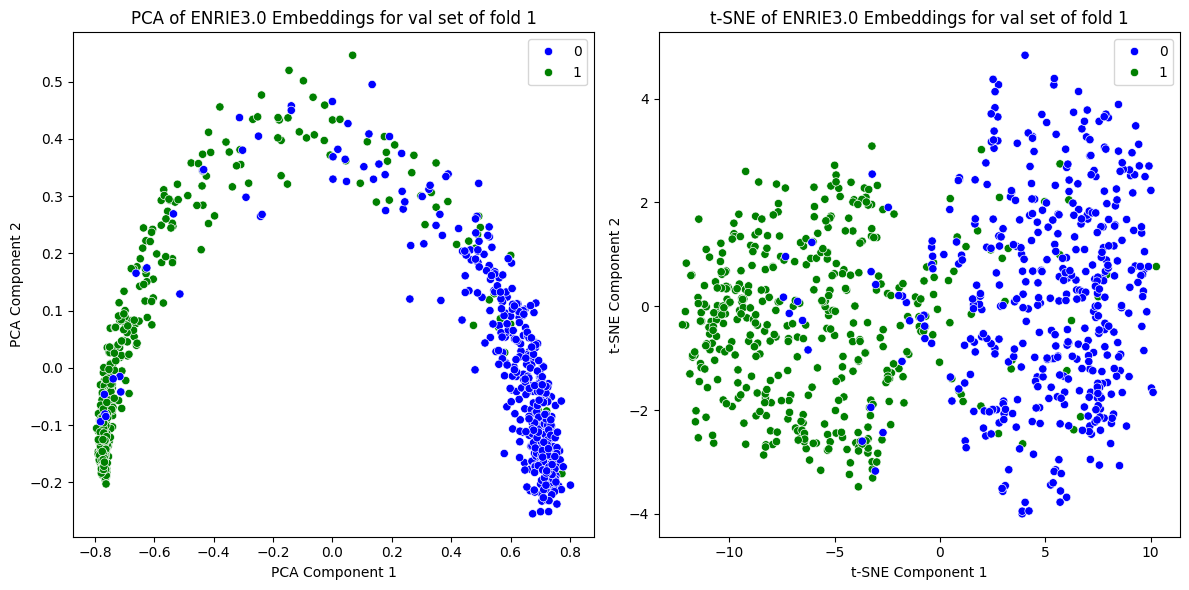

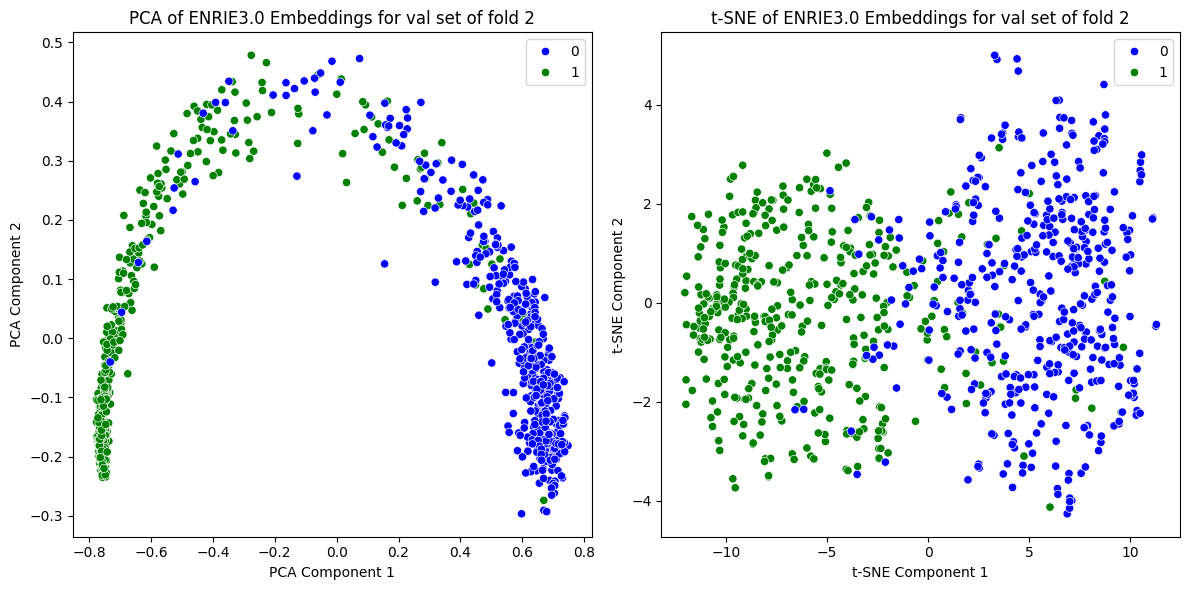

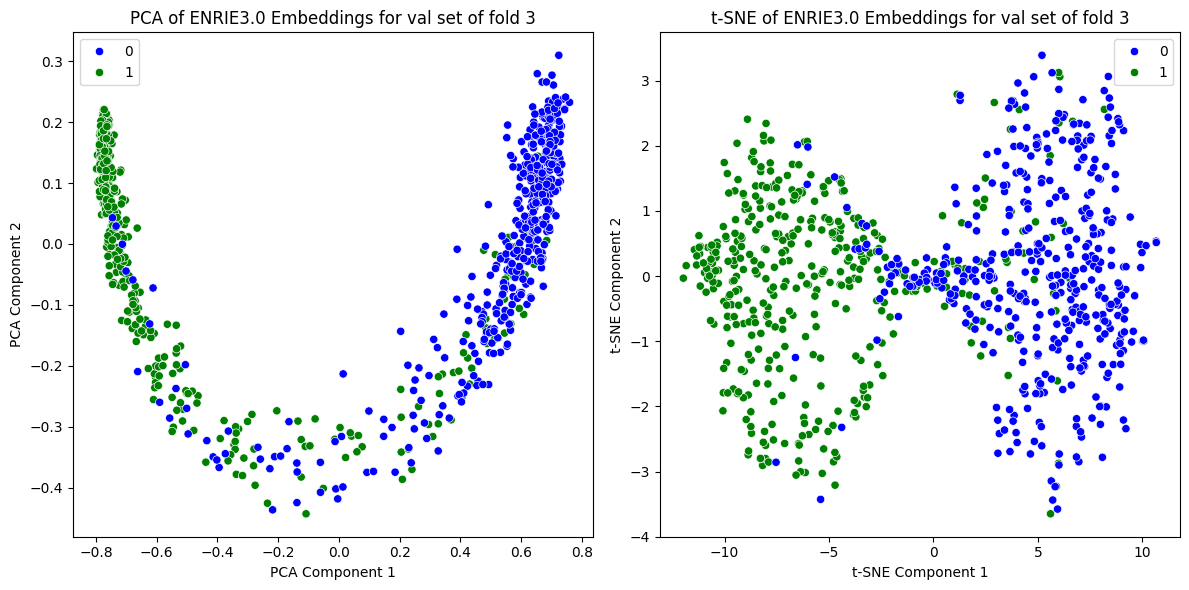

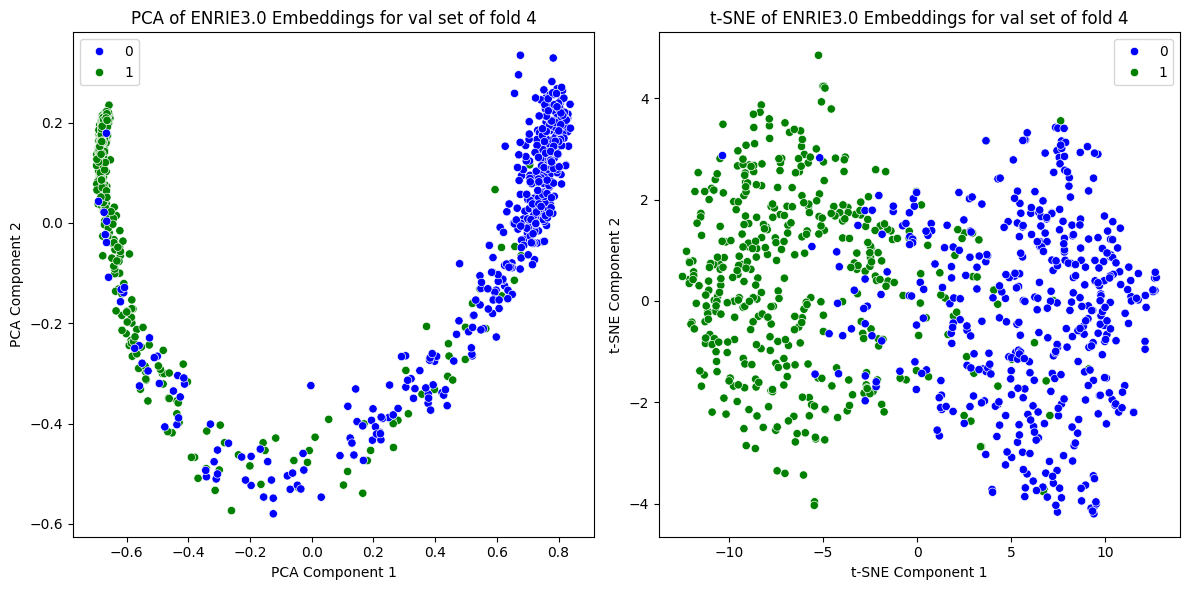

In [34]:
for fold_ids in range(K_FOLDS):
    data_index = fold_idx[fold_ids][1]

    dataset = PolarizationDataset({
        'texts': [df['text'][j] for j in data_index],
        'labels': [df['polarization'][j] for j in data_index]
    }, tokenizer=tokenizer)

    # Create a DataLoader for the training dataset
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE_EVAL, collate_fn=data_collator)

    embeddings, labels = get_embeddings_and_labels(model_list[fold_ids], dataloader)

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=2)
    pca_embeddings = pca.fit_transform(embeddings)

    # Apply t-SNE for dimensionality reduction (can be computationally intensive)
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=300)
    tsne_embeddings = tsne.fit_transform(embeddings)

    visualize(f'val set of fold {fold_ids}', pca_embeddings, tsne_embeddings, labels)